# Importing Essential Libraries

In [24]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
plt.style.use('ggplot')

In [2]:
real = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")
fake = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")

In [3]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


# Data Cleaning

In [5]:
real.subject.unique(),fake.subject.unique()

(array(['politicsNews', 'worldnews'], dtype=object),
 array(['News', 'politics', 'Government News', 'left-news', 'US_News',
        'Middle-east'], dtype=object))

The Subject and the Date the News was published will Not Play a Major Role in Determining if the News if Fake or Real So we will Drop It.

In [6]:
real['target'] = 1
fake['target'] = 0
df = pd.concat([real, fake]).reset_index(drop = True)
df.drop(['date','subject'],axis=1,inplace=True)
df.head()

,title,text,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [7]:
df.isna().sum()

title     0
text      0
target    0
dtype: int64

# Exploratory Data Analysis

In [8]:
sub_tf_df=df.groupby('target').apply(lambda x:x['title'].count()).reset_index(name='Counts')
sub_tf_df.target.replace({0:'False',1:'True'},inplace=True)
fig = px.bar(sub_tf_df, x="target", y="Counts",
             color='Counts', barmode='group',
             height=400)
fig.show()

In [9]:
df['text'] = df['title'] + df['text']
df.drop('title', axis=1, inplace=True)

In [10]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
            
    return result

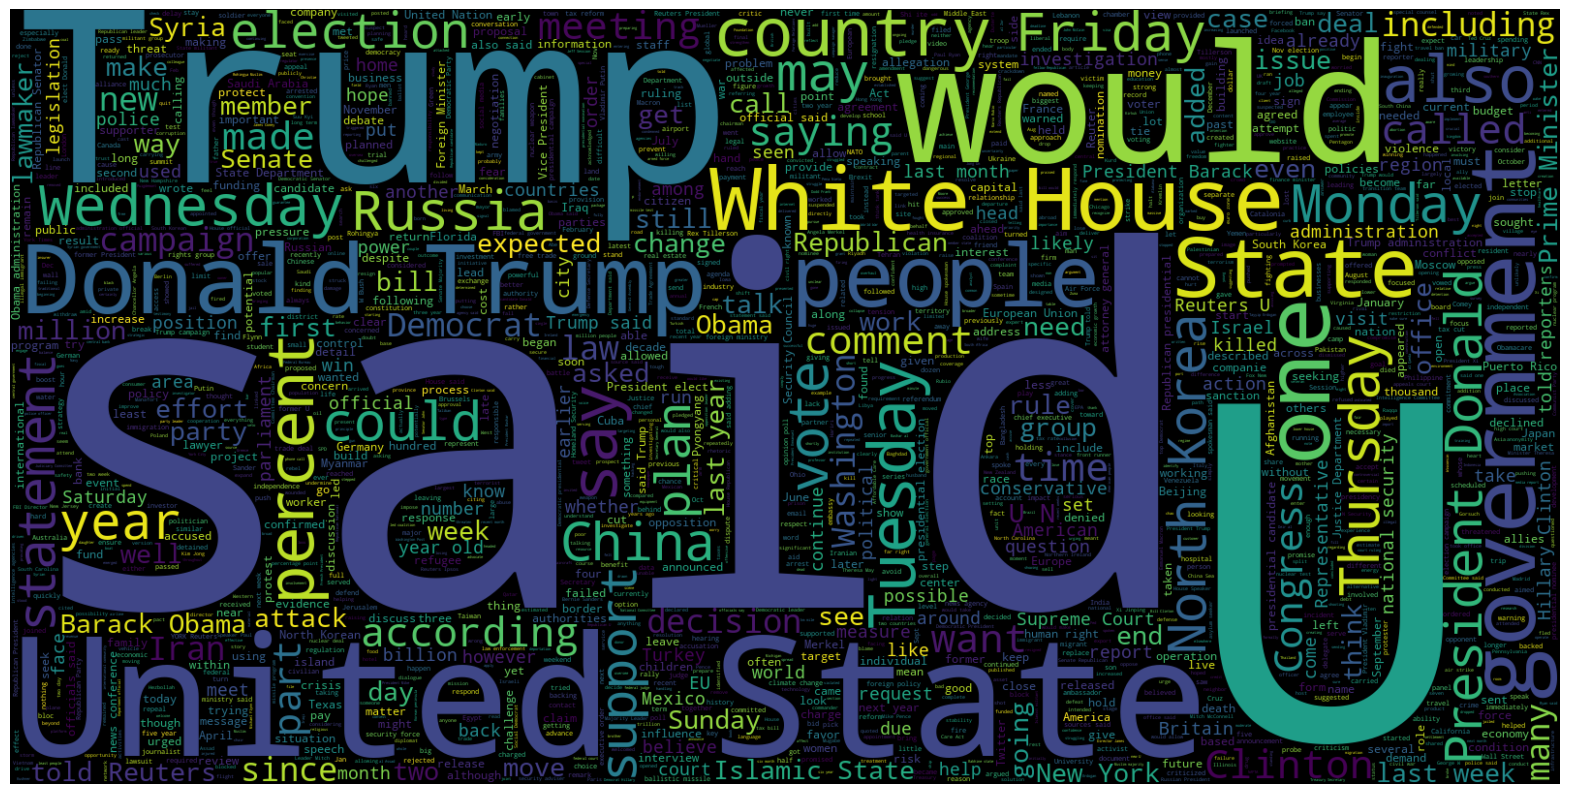

In [11]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].text))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off');

In [12]:
features = df['text']
targets = df['target']

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=42)

In [13]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [14]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

In [15]:
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [16]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=256)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=256)

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [18]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10,validation_split=0.1, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
1078/1078 [==============================] - 138s 115ms/step - loss: 0.3160 - accuracy: 0.8530 - val_loss: 0.1326 - val_accuracy: 0.9577
Epoch 2/10
1078/1078 [==============================] - 54s 50ms/step - loss: 0.0888 - accuracy: 0.9750 - val_loss: 0.0605 - val_accuracy: 0.9816
Epoch 3/10
1078/1078 [==============================] - 50s 47ms/step - loss: 0.0375 - accuracy: 0.9903 - val_loss: 0.0395 - val_accuracy: 0.9880
Epoch 4/10
1078/1078 [==============================] - 48s 45ms/step - loss: 0.0196 - accuracy: 0.9958 - val_loss: 0.0350 - val_accuracy: 0.9905
Epoch 5/10
1078/1078 [==============================] - 45s 42ms/step - loss: 0.0114 - accuracy: 0.9974 - val_loss: 0.0370 - val_accuracy: 0.9894
Epoch 6/10
1078/1078 [==============================] - 44s 41ms/step - loss: 0.0078 - accuracy: 0.9980 - val_loss: 0.0552 - val_accuracy: 0.9800


In [19]:
model.evaluate(X_test, y_test)

281/281 [==============================] - 5s 17ms/step - loss: 0.0375 - accuracy: 0.9901


[0.037530336529016495, 0.9900890588760376]

In [20]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

281/281 [==============================] - 7s 17ms/step


In [21]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9900890868596882
Precision on testing set: 0.9907621247113164
Recall on testing set: 0.9887070753629869


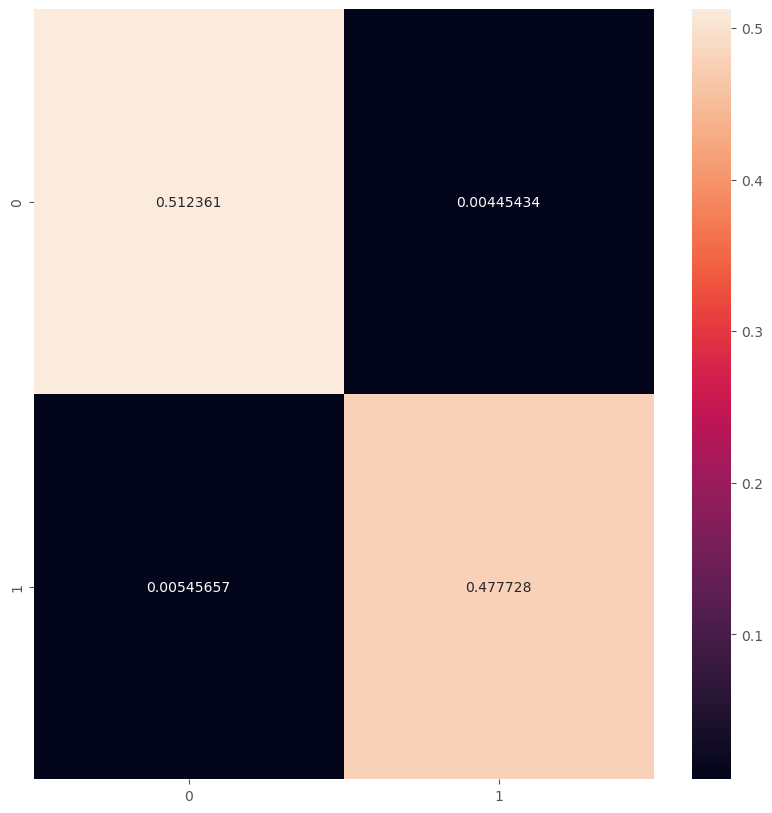

In [22]:
cm = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True,fmt='g');